In [1]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# sys.pathの設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

batch normalization

In [3]:
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from common import optimizer

# バッチ正規化layer
class BatchNormalization:
  '''
  gamma : スケール係数
  beta : オフセット
  momuntum : 慣性
  running_mean : テスト時に使用する平均
  running_var : テスト時に使用する分散
  '''
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.input_shape = None

    self.running_mean = running_mean
    self.running_var = running_var

    # backward時に使用する中間データ
    self.batch_size = None
    self.xc = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, x, train_flg=True):
    if self.running_mean is None:
      N, D = x.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    # バッチ正規化
    if train_flg:
      mu = x.mean(axis=0)  # 平均
      xc = x - mu  # x をセンタリング
      var = np.mean(xc**2, axis=0)  # 分散
      std = np.sqrt(var + 10e-7)  # スケーリング
      xn = xc / std

      self.batch_size = x.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std
      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu  # 平均値の加重平均
      self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var  # 分散値の加重平均
    else:
      xc = x - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
  

  def backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx



In [4]:
# multi_layer_net.pyをimportする代わりに処理を記載

import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common import layers

class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    weight_decay_lambda: L2正則化の強さ
    use_dropout: ドロップアウトの有無
    dropout_ratio: ドロップアウト率
    use_batchnorm: バッチ正規化の有無
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ratio = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = layers.BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = layers.Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, d, train_flg=False):
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, X, D):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if D.ndim != 1 : D = np.argmax(D, axis=1)

        accuracy = np.sum(Y == D) / float(X.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

Generation: 10.正答率（train) = 0.18
             :10.正答率(test) =0.2351
Generation: 20.正答率（train) = 0.52
             :20.正答率(test) =0.4976
Generation: 30.正答率（train) = 0.64
             :30.正答率(test) =0.6526
Generation: 40.正答率（train) = 0.69
             :40.正答率(test) =0.696
Generation: 50.正答率（train) = 0.69
             :50.正答率(test) =0.7316
Generation: 60.正答率（train) = 0.75
             :60.正答率(test) =0.7351
Generation: 70.正答率（train) = 0.73
             :70.正答率(test) =0.7569
Generation: 80.正答率（train) = 0.72
             :80.正答率(test) =0.771
Generation: 90.正答率（train) = 0.69
             :90.正答率(test) =0.7834
Generation: 100.正答率（train) = 0.79
             :100.正答率(test) =0.7799
Generation: 110.正答率（train) = 0.7
             :110.正答率(test) =0.7797
Generation: 120.正答率（train) = 0.79
             :120.正答率(test) =0.7943
Generation: 130.正答率（train) = 0.81
             :130.正答率(test) =0.8017
Generation: 140.正答率（train) = 0.82
             :140.正答率(test) =0.7981
Generation: 150.正答率（train) = 0.85
       

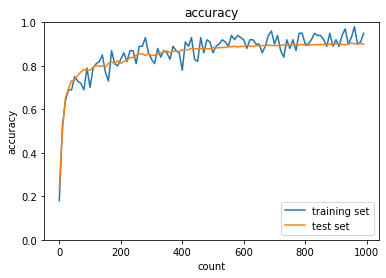

In [6]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

# batch_normalizationの適用
use_batchnorm = True

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
    network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()
